# Working with time series

The hope for this project is to practice using time series using three different approaches - ARIMA time series Analysis, Bayesian time series, and LSTM (hopefully in fastai - may have to be configured separately since it runs on a GPU). 

### Import libraries

In [1]:
#MCMC/ARIMA packages
import pymc3 as pm
import pmdarima as ar
import arviz as az
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

#data wrangling
import pandas as pd
import numpy as np

This is just monthly stock trend data for Salesforce (CRM), obtained from yahoo https://finance.yahoo.com/quote/crm/history/

In [2]:
CRM = pd.read_csv('data/CRM_daily.csv', index_col='Date',parse_dates=True)
#print(CRM.index)

In [3]:
CRM.head(12)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-06-23,3.7500,4.3250,3.6875,4.3000,4.3000,43574400
2004-06-24,4.3875,4.4225,4.1250,4.1900,4.1900,8887200
2004-06-25,4.1275,4.1875,3.9475,3.9500,3.9500,6710000
2004-06-28,4.0000,4.0525,3.8600,4.0000,4.0000,2270800
2004-06-29,4.0000,4.1750,3.9575,4.1000,4.1000,2112000
2004-06-30,4.1000,4.2350,4.0075,4.0175,4.0175,2087600
2004-07-01,4.0200,4.0500,3.9750,4.0075,4.0075,1754800
2004-07-02,4.0250,4.2450,4.0125,4.2450,4.2450,993200
2004-07-06,4.2325,4.2500,4.1200,4.2500,4.2500,1216800


In [4]:
CRM.shape

(4441, 6)

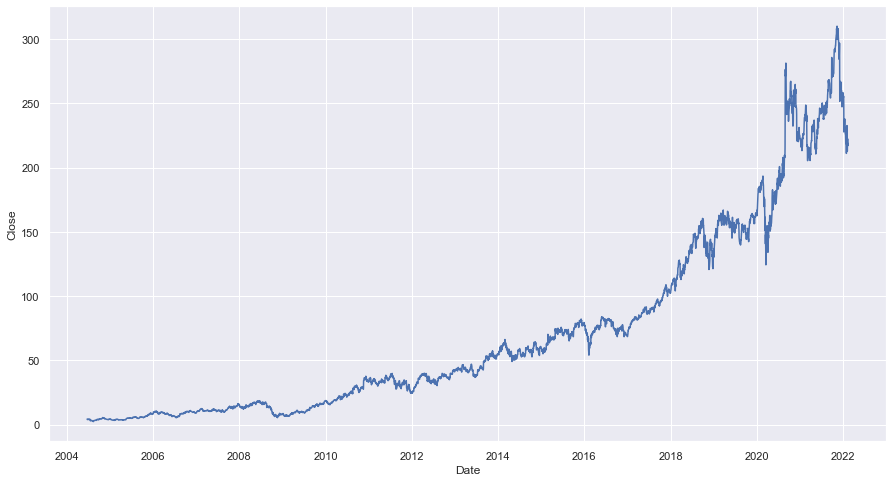

In [5]:
sns.set_theme()
sns.set(rc = {'figure.figsize':(15,8)})
p1 = sns.lineplot(
    data = CRM,
    x = "Date", y = "Close"
)

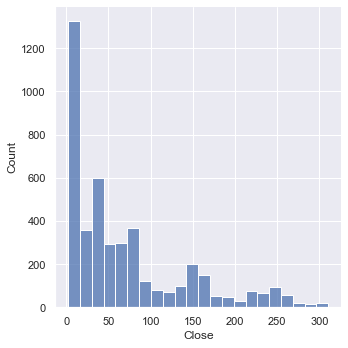

In [6]:
sns.displot(data = CRM, x="Close", binwidth = 14)

Closing price is non-normally distributed and trend is non-stationary, which is also confirmed below.

### Stationarity Check (Dickey Fuller)

In [7]:
ts_test = adfuller(CRM['Close'], autolag = 'AIC')
ts_test

(-0.06392047117515172,
 0.9529157133939834,
 31,
 4409,
 {'1%': -3.4318340352231185,
  '5%': -2.862195763748743,
  '10%': -2.567119067159428},
 19606.741882699625)

### Transformation using differences

Though the non-stationary mean issue is taken care of as part of ARIMA, I also wanted to visualize the transformation to understand what it does better, which is done below

In [8]:
CRM_stnry = CRM.diff().dropna(); CRM_stnry.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-06-24,0.6375,0.0975,0.4375,-0.1100,-0.1100,-34687200.0
2004-06-25,-0.2600,-0.2350,-0.1775,-0.2400,-0.2400,-2177200.0
2004-06-28,-0.1275,-0.1350,-0.0875,0.0500,0.0500,-4439200.0
2004-06-29,0.0000,0.1225,0.0975,0.1000,0.1000,-158800.0
2004-06-30,0.1000,0.0600,0.0500,-0.0825,-0.0825,-24400.0


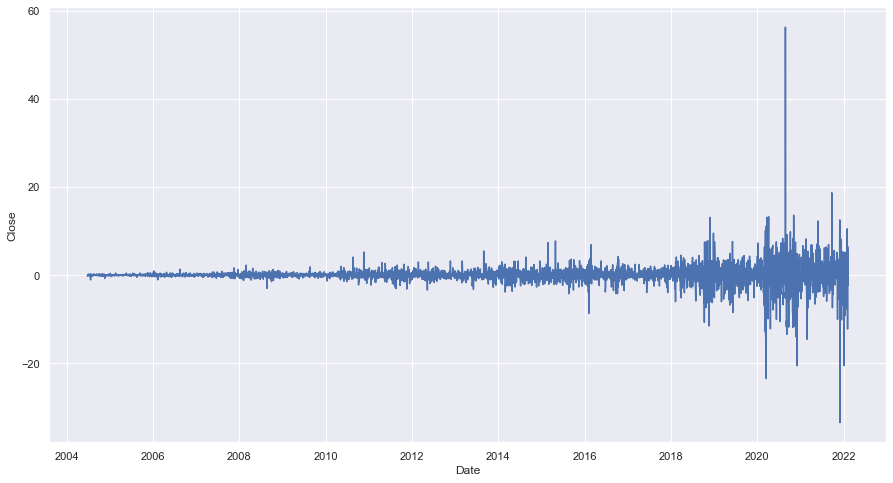

In [9]:
sns.set_theme()
sns.set(rc = {'figure.figsize':(15,8)})
p1 = sns.lineplot(
    data = CRM_stnry,
    x = "Date", y = "Close"
)

In [10]:
ts_test2 = adfuller(CRM_stnry['Close'], autolag = 'AIC')
ts_test2

(-11.284501171020382,
 1.429095098541365e-20,
 30,
 4409,
 {'1%': -3.4318340352231185,
  '5%': -2.862195763748743,
  '10%': -2.567119067159428},
 19601.313864077012)

Data is now stationary based on the ADF test, but we'll use the old data for ARIMA. 

### Modeling

In [13]:
#CRM.index = pd.DatetimeIndex(CRM.index).to_period('D')

In [20]:
test_arima_params = ar.auto_arima(CRM['Close'], trace = True, suppress_warnings = True)
test_arima_params.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19845.833, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19845.661, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19845.660, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19845.922, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19847.660, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=19847.659, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19849.607, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=19845.843, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 7.226 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4441
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -9919.830
Date:                Fri, 11 Feb 2022   AIC                          19845.660
Time:                        00:57:21   BIC                          19864.855
Sample:                             0   HQIC                         19852.428
                               - 4441                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0491      0.034      1.445      0.148      -0.017       0.116
ma.L1         -0.0222      0.006     -3.710      0.000      -0.034      -0.010
sigma2         5.1064      0.017    297.627      0.000       5.073       5.140
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2282772.77
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):             125.84   Skew:                             2.05
Prob(H) (two-sided):                  0.00   Kurtosis:                       114.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA(0,1,1) gives us the best AIC, so we'll use that in model fitting

In [18]:
arima_model = ARIMA(CRM['Close'], order = (0,1,1))
arima_fit = arima_model.fit()

In [19]:
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4441
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -9920.921
Date:                Fri, 11 Feb 2022   AIC                          19845.843
Time:                        00:55:28   BIC                          19858.640
Sample:                    06-23-2004   HQIC                         19850.355
                         - 02-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0217      0.006     -3.646      0.000      -0.033      -0.010
sigma2         5.1090      0.017    304.904      0.000       5.076       5.142
Ljung-Box (L1) (Q):                   0.00   Jarque-

Residuals are normally distributed with a mean very close to 0

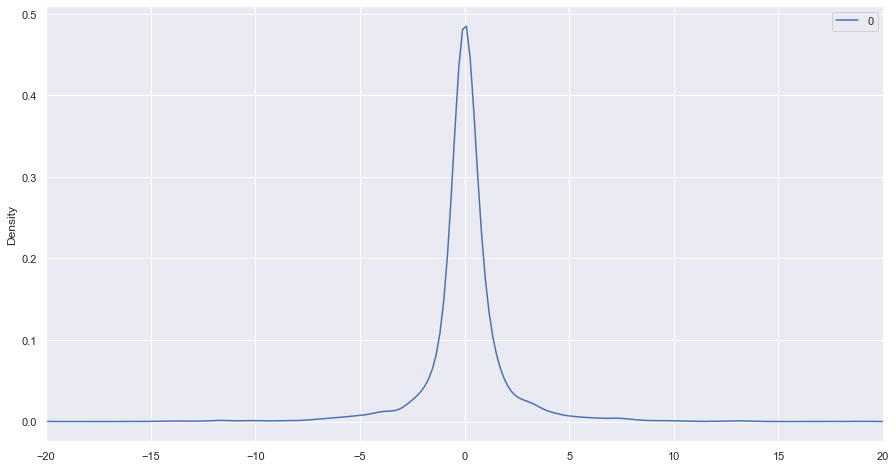

In [32]:
residuals.plot.kde()
plt.xlim(-20, 20)
plt.show()

### Forecasting

In [40]:
num_rows = len(CRM)
split_size = (num_rows * .85)
train = split_size
test = num_rows - split_size
print("TRAIN: %f   TEST: %f" %(train, test))

TRAIN: 3774.850000   TEST: 666.150000
